In [ ]:
import csv
import json
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq
from scipy import interpolate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from scipy import ndimage as ndi
from skimage import feature
from skimage.measure import block_reduce
from skimage import color
from scipy.signal import convolve2d as conv2

In [152]:
start = './chat/'

def file_tree(start):
    """Generate file list in directory"""
    file_list = []
    for root, dirs, files in os.walk(start):
        for f in files:
            if f[0] != '.':
                file_list.append(f)
    return file_list


def process_data(data):
    """Process JSON data"""
    attr = data['attributes']

    timestamp = attr['timestamp']
    message = attr['message']
    author = attr['from']
    turbo = attr['tags']['turbo']
    sub = attr['tags']['subscriber']

    try:
        emotes = attr['tags']['emotes']
        emote_count = sum([len(emotes[key]) for key in emotes.keys()])
    except:
        emote_count = 0
    
    row = {
        'timestamp': timestamp,
        'author': author,
        'message': message,
        'turbo': turbo,
        'sub': sub,
        'emote_count': emote_count
    }

    return row


def high_pass_filter(freq, amp, min_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index < min_freq] = 0
    return df

def low_pass_filter(freq, amp, max_freq):
    df = pd.DataFrame(amp, index=freq, columns=['Amplitude'])
    df = df.copy()
    df[df.index > max_freq] = 0
    return df

def round_to_val(x, val=30):
    return int(np.round(x/val) * val)

In [65]:
# Get file list
file_list = file_tree(start)
df = []

# Aggregate files into dictionary
for file in file_list:
    get_path = os.path.join(start, file)
    with open(get_path) as f:
        # Format line and separate multiple JSON strings with commas
        line = '[{}]'.format(f.readline()).replace('}}{', '}},{')
        data = json.loads(line)[0]

        for message in data['data']:
            df.append(process_data(message))

# Create data frame from chat data
df = pd.DataFrame(df)

In [66]:
minimum = df['timestamp'].min()
maximum = df['timestamp'].max()
df['timestamp'] = df['timestamp'].apply(lambda x: x - minimum)
df['secondstamp'] = df['timestamp'].apply(lambda x: int(round(x/1000)))

In [5]:
df.iloc[range(100,106)]

,author,emote_count,message,sub,timestamp,turbo,secondstamp
100,dou187,1,PogChamp,False,23635,False,24
101,ramvila,1,PogChamp,False,23877,False,24
102,bryceftww,1,JUST A CLOCK BRO ANELE,False,24013,False,24
103,memoli3814,0,ssssssssssssssssssssssssssssssssss,False,24019,False,24
104,jackgiese11,0,LETS GO,False,24087,False,24
105,whzbans,5,,False,24271,False,24


In [6]:
counts = df['secondstamp'].value_counts().sort_index()

In [164]:
x = counts.index.values
y = counts.values

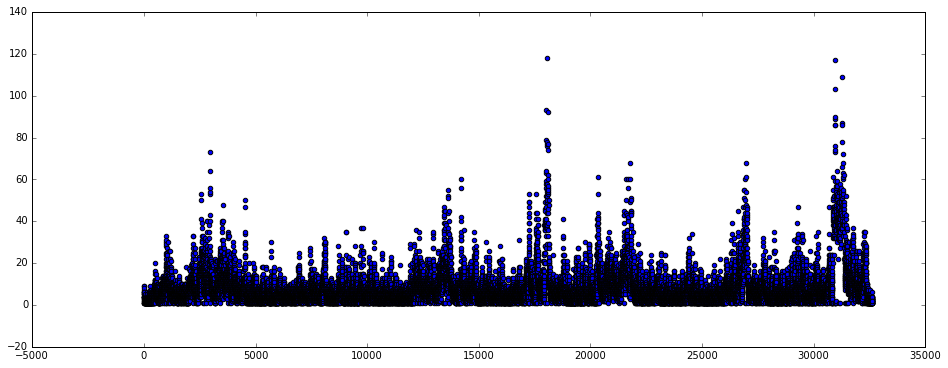

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.scatter(x, y)
plt.show()

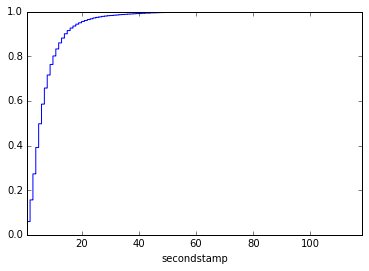

In [9]:
# Generate CDF
cdf = counts.sort_values()
cum_dist = np.linspace(0.,1.,len(cdf))
cdf = pd.Series(cum_dist, index=cdf)
cdf.plot(drawstyle='steps')

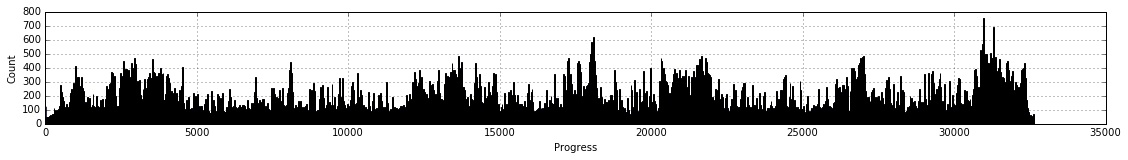

In [121]:
fig = plt.figure(figsize=(19,2))
ax = df['secondstamp'].hist(bins=len(file_list))
# ax = df['secondstamp'].hist(bins=90)
ax.set_xlabel('Progress')
ax.set_ylabel('Count')

In [125]:
count, division = np.histogram(list(df['secondstamp']), bins=len(file_list))

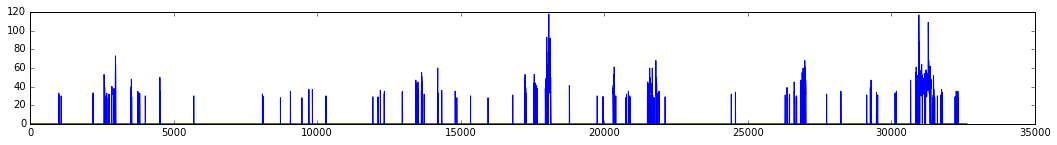

In [172]:
time = x
signal = y

W = rfftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

filtered = y
filtered[y < 4*np.std(y)] = 0

plt.figure(figsize=(18,2))
plt.subplot(111)
plt.plot(time,signal)
plt.show()

In [179]:
with open('test.csv', 'w') as f:
    writer = csv.writer(f, delimiter="\n")
    writer.writerow(time[filtered > 0])

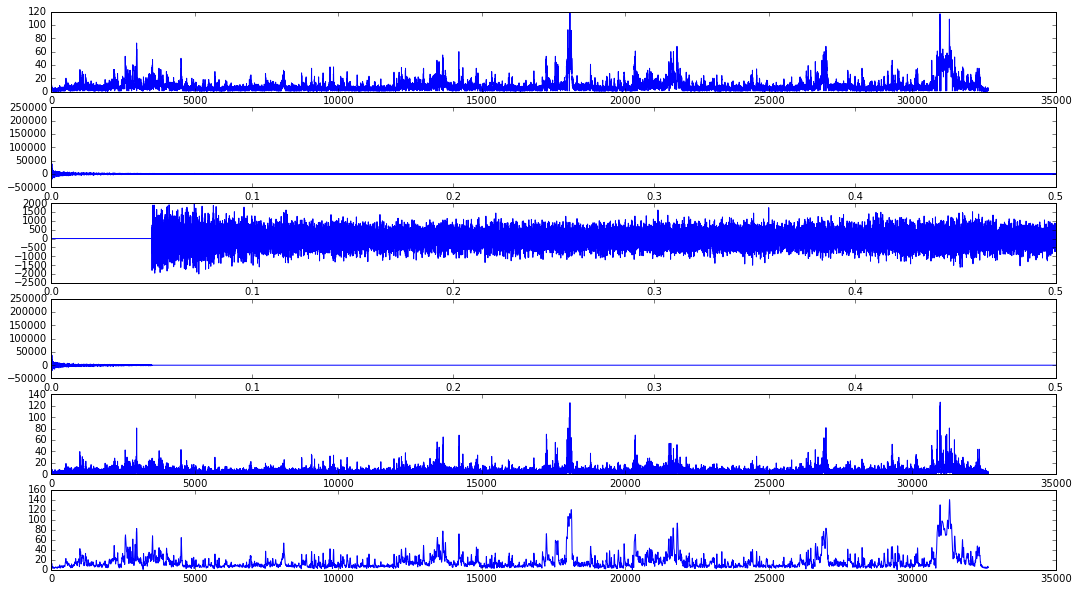

In [157]:
time = x
signal = y

W = rfftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

band = 0.05
plt.figure(figsize=(18,10))
plt.subplot(611)
plt.plot(time,signal)
plt.subplot(612)
plt.plot(W,f_signal)
plt.subplot(613)
plt.plot(W, high_pass_filter(W, f_signal, band))
plt.subplot(614)
plt.plot(W, low_pass_filter(W, f_signal, band))
plt.subplot(615)
filtered = 2*abs(irfft(high_pass_filter(W, f_signal, band)['Amplitude'], len(high_pass_filter(W, f_signal, band)['Amplitude'])))
plt.plot(time, filtered)
plt.subplot(616)
filtered = 2*abs(irfft(low_pass_filter(W, f_signal, band)['Amplitude'], len(low_pass_filter(W, f_signal, band)['Amplitude'])))
plt.plot(time, filtered)
plt.show()

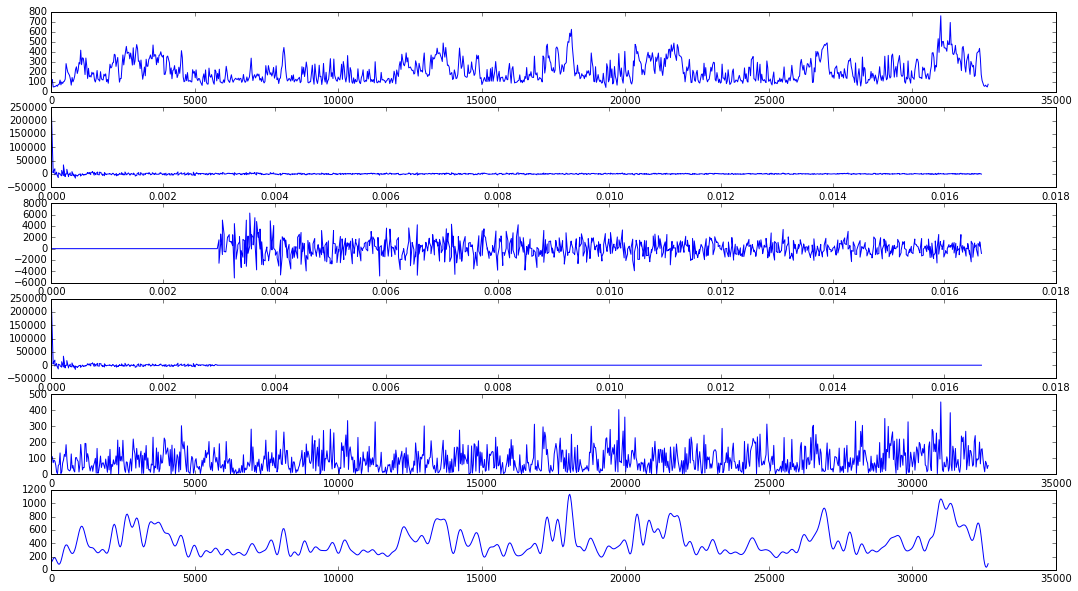

In [160]:
count, division = np.histogram(list(df['secondstamp']), bins=len(file_list))

time = division[1:]
signal = count

W = rfftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

band = 0.003
plt.figure(figsize=(18,10))
plt.subplot(611)
plt.plot(time,signal)
plt.subplot(612)
plt.plot(W,f_signal)
plt.subplot(613)
plt.plot(W, high_pass_filter(W, f_signal, band))
plt.subplot(614)
plt.plot(W, low_pass_filter(W, f_signal, band))
plt.subplot(615)
filtered = 2*abs(irfft(high_pass_filter(W, f_signal, band)['Amplitude'], len(high_pass_filter(W, f_signal, band)['Amplitude'])))
plt.plot(time, filtered)
plt.subplot(616)
filtered = 2*abs(irfft(low_pass_filter(W, f_signal, band)['Amplitude'], len(low_pass_filter(W, f_signal, band)['Amplitude'])))
plt.plot(time, filtered)
plt.show()

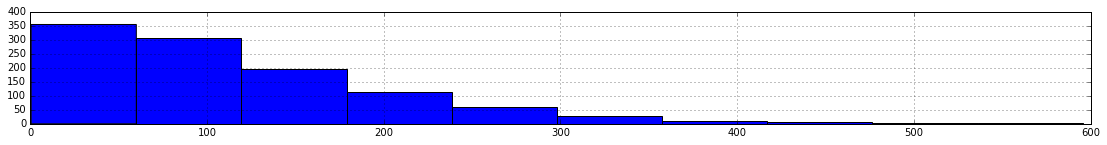

In [154]:
fig = plt.figure(figsize=(19,2))
flt = pd.DataFrame(filtered, index=time)
ax = flt[0].hist()